In [1]:
import os 
import time
import sys 
import json
from argparse import Namespace

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder

import matplotlib.pyplot as plt
from PIL import Image

from transformers import CLIPProcessor, CLIPModel, BlipModel, BlipProcessor, BlipForConditionalGeneration

from tqdm import tqdm
import random

import kagglehub

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(device)
device=torch.device(device)

cuda


In [3]:
class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model
        self.classifier = nn.Linear(model.visual.output_dim, num_classes)
    
    def forward(self, x):    
        features = self.model.encode_image(x).float()  # Convert to float32
        return self.classifier(features)

In [4]:
class BLIPClassifier(nn.Module):
    def __init__(self, blip_model, num_classes):
        super(BLIPClassifier, self).__init__()
        self.encoder = blip_model.vision_model
        self.classifier = nn.Linear(768, num_classes)

    def forward(self, pixel_values):
        image_outputs = self.encoder(pixel_values=pixel_values)
        cls_token = image_outputs.last_hidden_state[:, 0, :]  # [B, 768]
        return self.classifier(cls_token)

In [5]:
# Download latest version
path = kagglehub.dataset_download("imbikramsaha/caltech-101")

print("Path to dataset files:", path)

Path to dataset files: /home/danyil.vaida/.cache/kagglehub/datasets/imbikramsaha/caltech-101/versions/1


In [6]:
rootdir = os.path.abspath(path)

for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        if not file.endswith(".jpg"):
            filepath = subdir + os.sep + file
            print(filepath)

/home/danyil.vaida/.cache/kagglehub/datasets/imbikramsaha/caltech-101/versions/1/caltech-101/BACKGROUND_Google/tmp


In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
ds = ImageFolder("/home/danyil.vaida/.cache/kagglehub/datasets/imbikramsaha/caltech-101/versions/1/caltech-101", transform=transform)

In [8]:
include_classes = ['airplanes', 'camera', 'car', 'cellphone', 'chair', 'cup', 'elephant', 'human', 'laptop']
class_to_idx = {cls: idx for cls, idx in ds.class_to_idx.items() if cls in include_classes}

filtered_samples = [sample for sample in ds.samples if sample[1] in class_to_idx.values()]
ds.samples = filtered_samples
ds.targets = [s[1] for s in filtered_samples]
ds.class_to_idx = class_to_idx

In [9]:
# Split dataset into training and validation sets
train_size = int(0.8 * len(ds))
val_size = len(ds) - train_size
train_dataset, val_dataset = random_split(ds, [train_size, val_size])

In [10]:
batch_size = 32
num_classes = len(ds.class_to_idx)
num_epochs = 15

In [11]:
def remap_labels(labels, class_to_idx):
    # Build a reverse mapping: original idx → 0–8
    idx_remap = {orig_idx: i for i, orig_idx 
                 in enumerate(sorted(class_to_idx.values()))}
    remapped_labels = torch.tensor([idx_remap[label.item()] for label in labels])
    return remapped_labels

def one_hot_labels(labels, class_to_idx):
    remapped_labels = remap_labels(labels, class_to_idx)
    #one_hot = F.one_hot(remapped_labels, num_classes=len(class_to_idx)).float()
    return F.one_hot(remapped_labels, num_classes=num_classes).float()

In [17]:
# Create DataLoader for training and validation sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [13]:
"""
# OpenAI CLIP model and preprocessing
model, preprocess = clip.load("ViT-B/32", jit=False)
"""

"""
# Load model and processor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)

# Load and preprocess image
image = Image.open("imgs/000000000776.jpg").convert("RGB")
inputs = processor(images=image, return_tensors="pt").to(device)

# Generate caption
output = model.generate(**inputs, max_new_tokens=30)
caption = processor.decode(output[0], skip_special_tokens=True)

# Access encoder outputs
image_outputs = model.vision_model(**inputs)  # Returns last hidden states
image_embeds = image_outputs.last_hidden_state  # Shape: [1, seq_len, hidden_dim]
cls_token_embed = image_embeds[:, 0, :]  # [1, hidden_dim] - use this for classification
"""

'\n# Load model and processor\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nprocessor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")\nmodel = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)\n\n# Load and preprocess image\nimage = Image.open("imgs/000000000776.jpg").convert("RGB")\ninputs = processor(images=image, return_tensors="pt").to(device)\n\n# Generate caption\noutput = model.generate(**inputs, max_new_tokens=30)\ncaption = processor.decode(output[0], skip_special_tokens=True)\n\n# Access encoder outputs\nimage_outputs = model.vision_model(**inputs)  # Returns last hidden states\nimage_embeds = image_outputs.last_hidden_state  # Shape: [1, seq_len, hidden_dim]\ncls_token_embed = image_embeds[:, 0, :]  # [1, hidden_dim] - use this for classification\n'

In [12]:
# Load model and processor
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
model_ft = BLIPClassifier(blip_model=model, num_classes=num_classes).to(device)
model_pedik = model

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.classifier.parameters(), lr=1e-4)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [13]:
"""
# Training loop
for epoch in range(num_epochs):
    model_ft.train()
    for param in model_ft.encoder.parameters():
        param.requires_grad = False

    for param in model_ft.classifier.parameters():
        param.requires_grad = True
        
    running_loss = 0.0  # Initialize running loss for the current epoch
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")
    
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(device), labels.to(device)
        one_hot = one_hot_labels(labels, ds.class_to_idx).to(device)
        
        optimizer.zero_grad()
        outputs = model_ft(images)
        loss = criterion(outputs, one_hot)
        loss.backward()  
        optimizer.step()
        
        running_loss += loss.item()
        avg_loss = running_loss / (batch_idx + 1)
        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}, Loss: {avg_loss:.4f}")

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Validation
    model_ft.eval()  
    correct = 0  
    total = 0 
    
    with torch.no_grad():  # Disable gradient calculation for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            remaped_labels = remap_labels(labels, ds.class_to_idx).to(device)
            
            outputs = model_ft(images)  
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)  
            correct += (predicted == remaped_labels).sum().item() 

    print(f'Validation Accuracy: {100 * correct / total}%')  

# Save the fine-tuned model
torch.save(model_ft.state_dict(), 'blip_finetuned.pth')  # Save the model's state dictionary
"""

'\n# Training loop\nfor epoch in range(num_epochs):\n    model_ft.train()\n    for param in model_ft.encoder.parameters():\n        param.requires_grad = False\n\n    for param in model_ft.classifier.parameters():\n        param.requires_grad = True\n        \n    running_loss = 0.0  # Initialize running loss for the current epoch\n    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Loss: 0.0000")\n    \n    for batch_idx, (images, labels) in enumerate(pbar):\n        images, labels = images.to(device), labels.to(device)\n        one_hot = one_hot_labels(labels, ds.class_to_idx).to(device)\n        \n        optimizer.zero_grad()\n        outputs = model_ft(images)\n        loss = criterion(outputs, one_hot)\n        loss.backward()  \n        optimizer.step()\n        \n        running_loss += loss.item()\n        avg_loss = running_loss / (batch_idx + 1)\n        pbar.set_description(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}, Loss: {avg_loss:.4f}")\n\n    pri

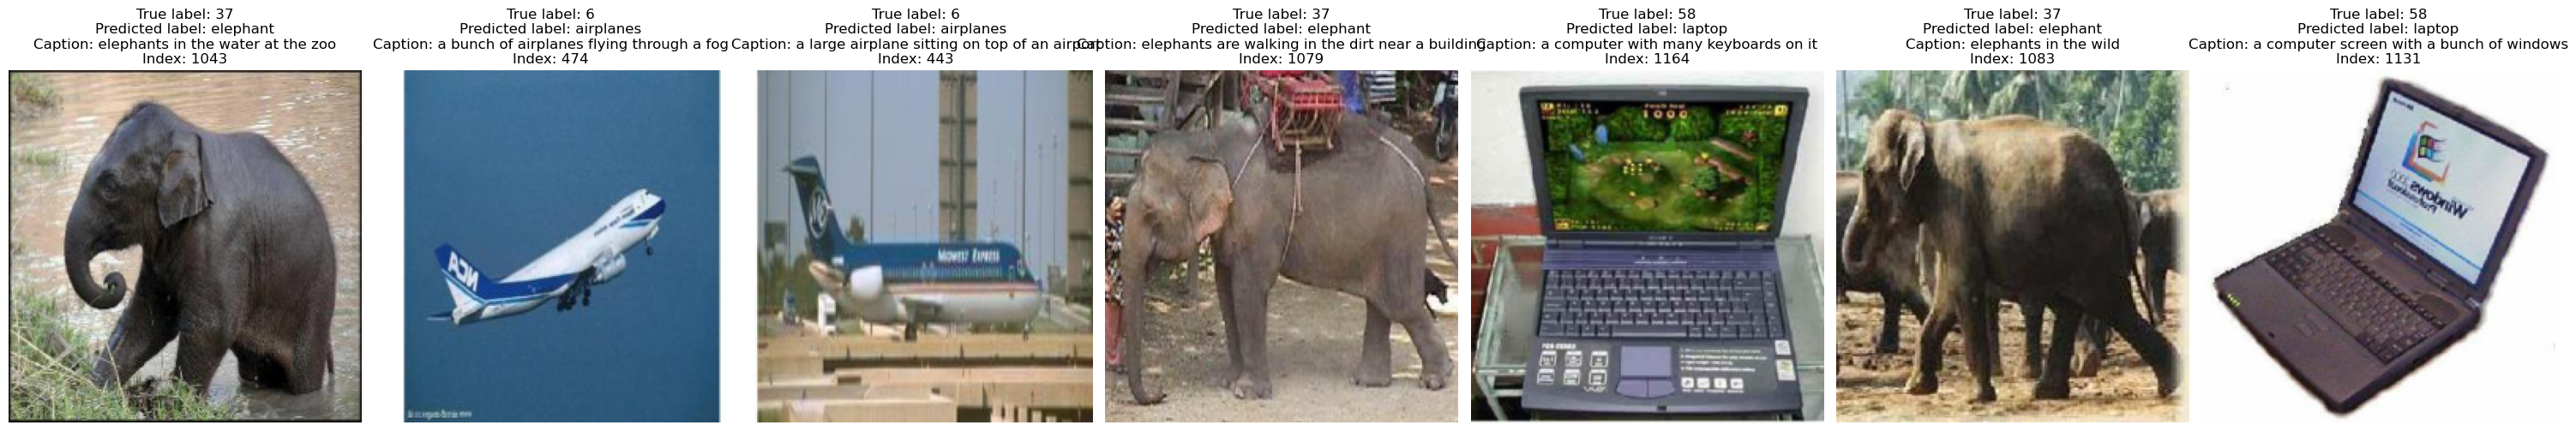

In [14]:
# Load the saved model weights
model_ft.load_state_dict(torch.load('blip_finetuned.pth'))
model_ft.eval()  # Set the model to evaluation mode
random_idxs = [1043, 474,443,1079,1164,1083,1131]

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create a figure with subplots
fig, axes = plt.subplots(1, 7, figsize=(30, 10))
plt.subplots_adjust(wspace=0.5)

# Loop through the indices and process each image
for i, idx in enumerate(random_idxs):
    # Get the image and label from the dataset
    image = ds[idx][0].to(device)
    true_label = ds[idx][1]

    image_tensor = image
    # Perform inference
    with torch.no_grad():
        output = model_ft(image_tensor.unsqueeze(0))
        _, predicted_label_idx = torch.max(output, 1)
        
        predicted_label = list(ds.class_to_idx.keys())[predicted_label_idx.item()]

        inputs = {'pixel_values': image_tensor.unsqueeze(0)}
        output = model.generate(**inputs, max_new_tokens=10)
        caption = processor.decode(output[0], skip_special_tokens=True)
        

    # Display the image in the subplot
    axes[i].imshow(image.cpu().permute(1, 2, 0))
    axes[i].set_title(f'True label: {true_label}\nPredicted label: {predicted_label}\nCaption: {caption}\nIndex: {idx}')
    axes[i].axis('off')
# Show the plot
plt.tight_layout()
plt.show()

In [15]:
class BlurWrapper(nn.Module):
    def __init__(self, model,blur_kernel_size=None):
        super(CLIPFineTuner, self).__init__()
        self.model = model
        self.blur_kernel_size = blur_kernel_size
    
    def forward(self, x):
        features = self.model.encode_image(x).float()  # Convert to float32
        return self.classifier(features)

In [19]:
def get_random_subset_loader(dataset, percent=0.1, batch_size=32, shuffle=True):
    total_size = len(dataset)
    subset_size = int(total_size * percent)

    # Randomly sample unique indices
    indices = random.sample(range(total_size), subset_size)

    # Create a Subset
    subset = Subset(dataset, indices)

    # Create a DataLoader
    loader = DataLoader(subset, batch_size=batch_size, shuffle=shuffle)

    return loader

# %%
num_examples = 100
batch_size = 32
seed = 42

test_loader = val_loader
# %%
for blur_kernel_size in [5]: #, 13, None,5,9]:
    if blur_kernel_size is None:
        model = model_ft
    else:
        sigma = (blur_kernel_size-1)/6
        blur = transforms.GaussianBlur(blur_kernel_size,sigma)
        model = torch.nn.Sequential(blur,model_ft)

    model = model.to(device)
    
    for bound in [4]:
        eps = bound/255
        iter_per_attack = 100 #25
        if blur_kernel_size is not None:
            base = "./adversarial_attacks"+"/BLIPClf"+f"/blured{blur_kernel_size}"+f"/eps{bound}"+f"/it{iter_per_attack}_exNum{num_examples}"
        else:
            base = "./adversarial_attacks"+"/BLIPClf"+"/blured_"+f"/eps{bound}"+f"/it{iter_per_attack}_exNum{num_examples}"
        attacks_file_name = base + ".pt" 
        captions_file = base+".json"

        # %%
        # GENERATING ADVERSARIAL EXAMPLES
        
        # attacker = Attacker(model,torch.nn.CrossEntropyLoss(),device, num_iterations=iter_per_attack, epsilon=eps)
        # pert_fn = attacker.perturbCLIPClassifier

        from autoattack import AutoAttack
        model.requires_grad_ = True
        adversary = AutoAttack(model, norm='Linf', eps=eps, version='standard')
        print()
        adversary.apgd_targeted.n_target_classes = num_classes - 1
        adversary.fab.n_target_classes = num_classes - 1
        pert_fn = lambda x,y: adversary.run_standard_evaluation(x,y,batch_size)
        
        
        print(attacks_file_name)
        if not os.path.exists(attacks_file_name):
            attacks = []
            overall_examples = 0
            counter_adv  = 0
            counter_clean = 0 
            for i,batch in enumerate(test_loader):
                
                if i*batch_size >= num_examples:
                    break 
                
                images, labels = batch
                one_hot = one_hot_labels(labels, ds.class_to_idx)
                real_labels = torch.argmax(one_hot,dim=-1)

                # from torch.autograd import grad

                # x = torch.randn(1, 3, 224, 224, requires_grad=True)
                # out = model(x.to(device))
                # loss = torch.nn.CrossEntropyLoss()(out, torch.tensor([0]).to(device))

                # grads = grad(loss, x, retain_graph=True, allow_unused=True)
                # print(grads)  # See if it's None
                x = batch[0].to(device).clone().detach().requires_grad_(True)
                y = real_labels.to(device)
                pert = pert_fn(x,y)
                #p_out = model(torch.clamp((batch[0].to(device)+pert.to(device)),0,1))
                p_out = model(torch.clamp(pert.to(device),0,1))
                out = model(batch[0].to(device))
                
                overall_examples += len(out)
                counter_adv += (torch.argmax(p_out,dim = -1)==real_labels.to(device)).sum().item()
                counter_clean += (torch.argmax(out,dim = -1)==real_labels.to(device)).sum().item()

                pert = pert.detach().cpu()
                attacks.append(pert)

            print("\nclean acc:",counter_clean/overall_examples)
            print("adv acc:",counter_adv/overall_examples)

            perts = torch.cat(attacks)
            #torch.save(perts,attacks_file_name)
        else:
            perts = torch.load(attacks_file_name)

setting parameters for standard version

./adversarial_attacks/BLIPClf/blured5/eps4/it100_exNum100.pt
using standard version including apgd-ce, apgd-t, fab-t, square.
initial accuracy: 93.75%
apgd-ce - 1/1 - 30 out of 30 successfully perturbed
robust accuracy after APGD-CE: 0.00% (total time 46.1 s)
max Linf perturbation: 0.01569, nan in tensor: 0, max: 1.00000, min: 0.00000
robust accuracy: 0.00%
max and min here tensor(0.0157, device='cuda:0') tensor(-0.0157, device='cuda:0')
clean acc: 0.9375
adv acc: 0.0


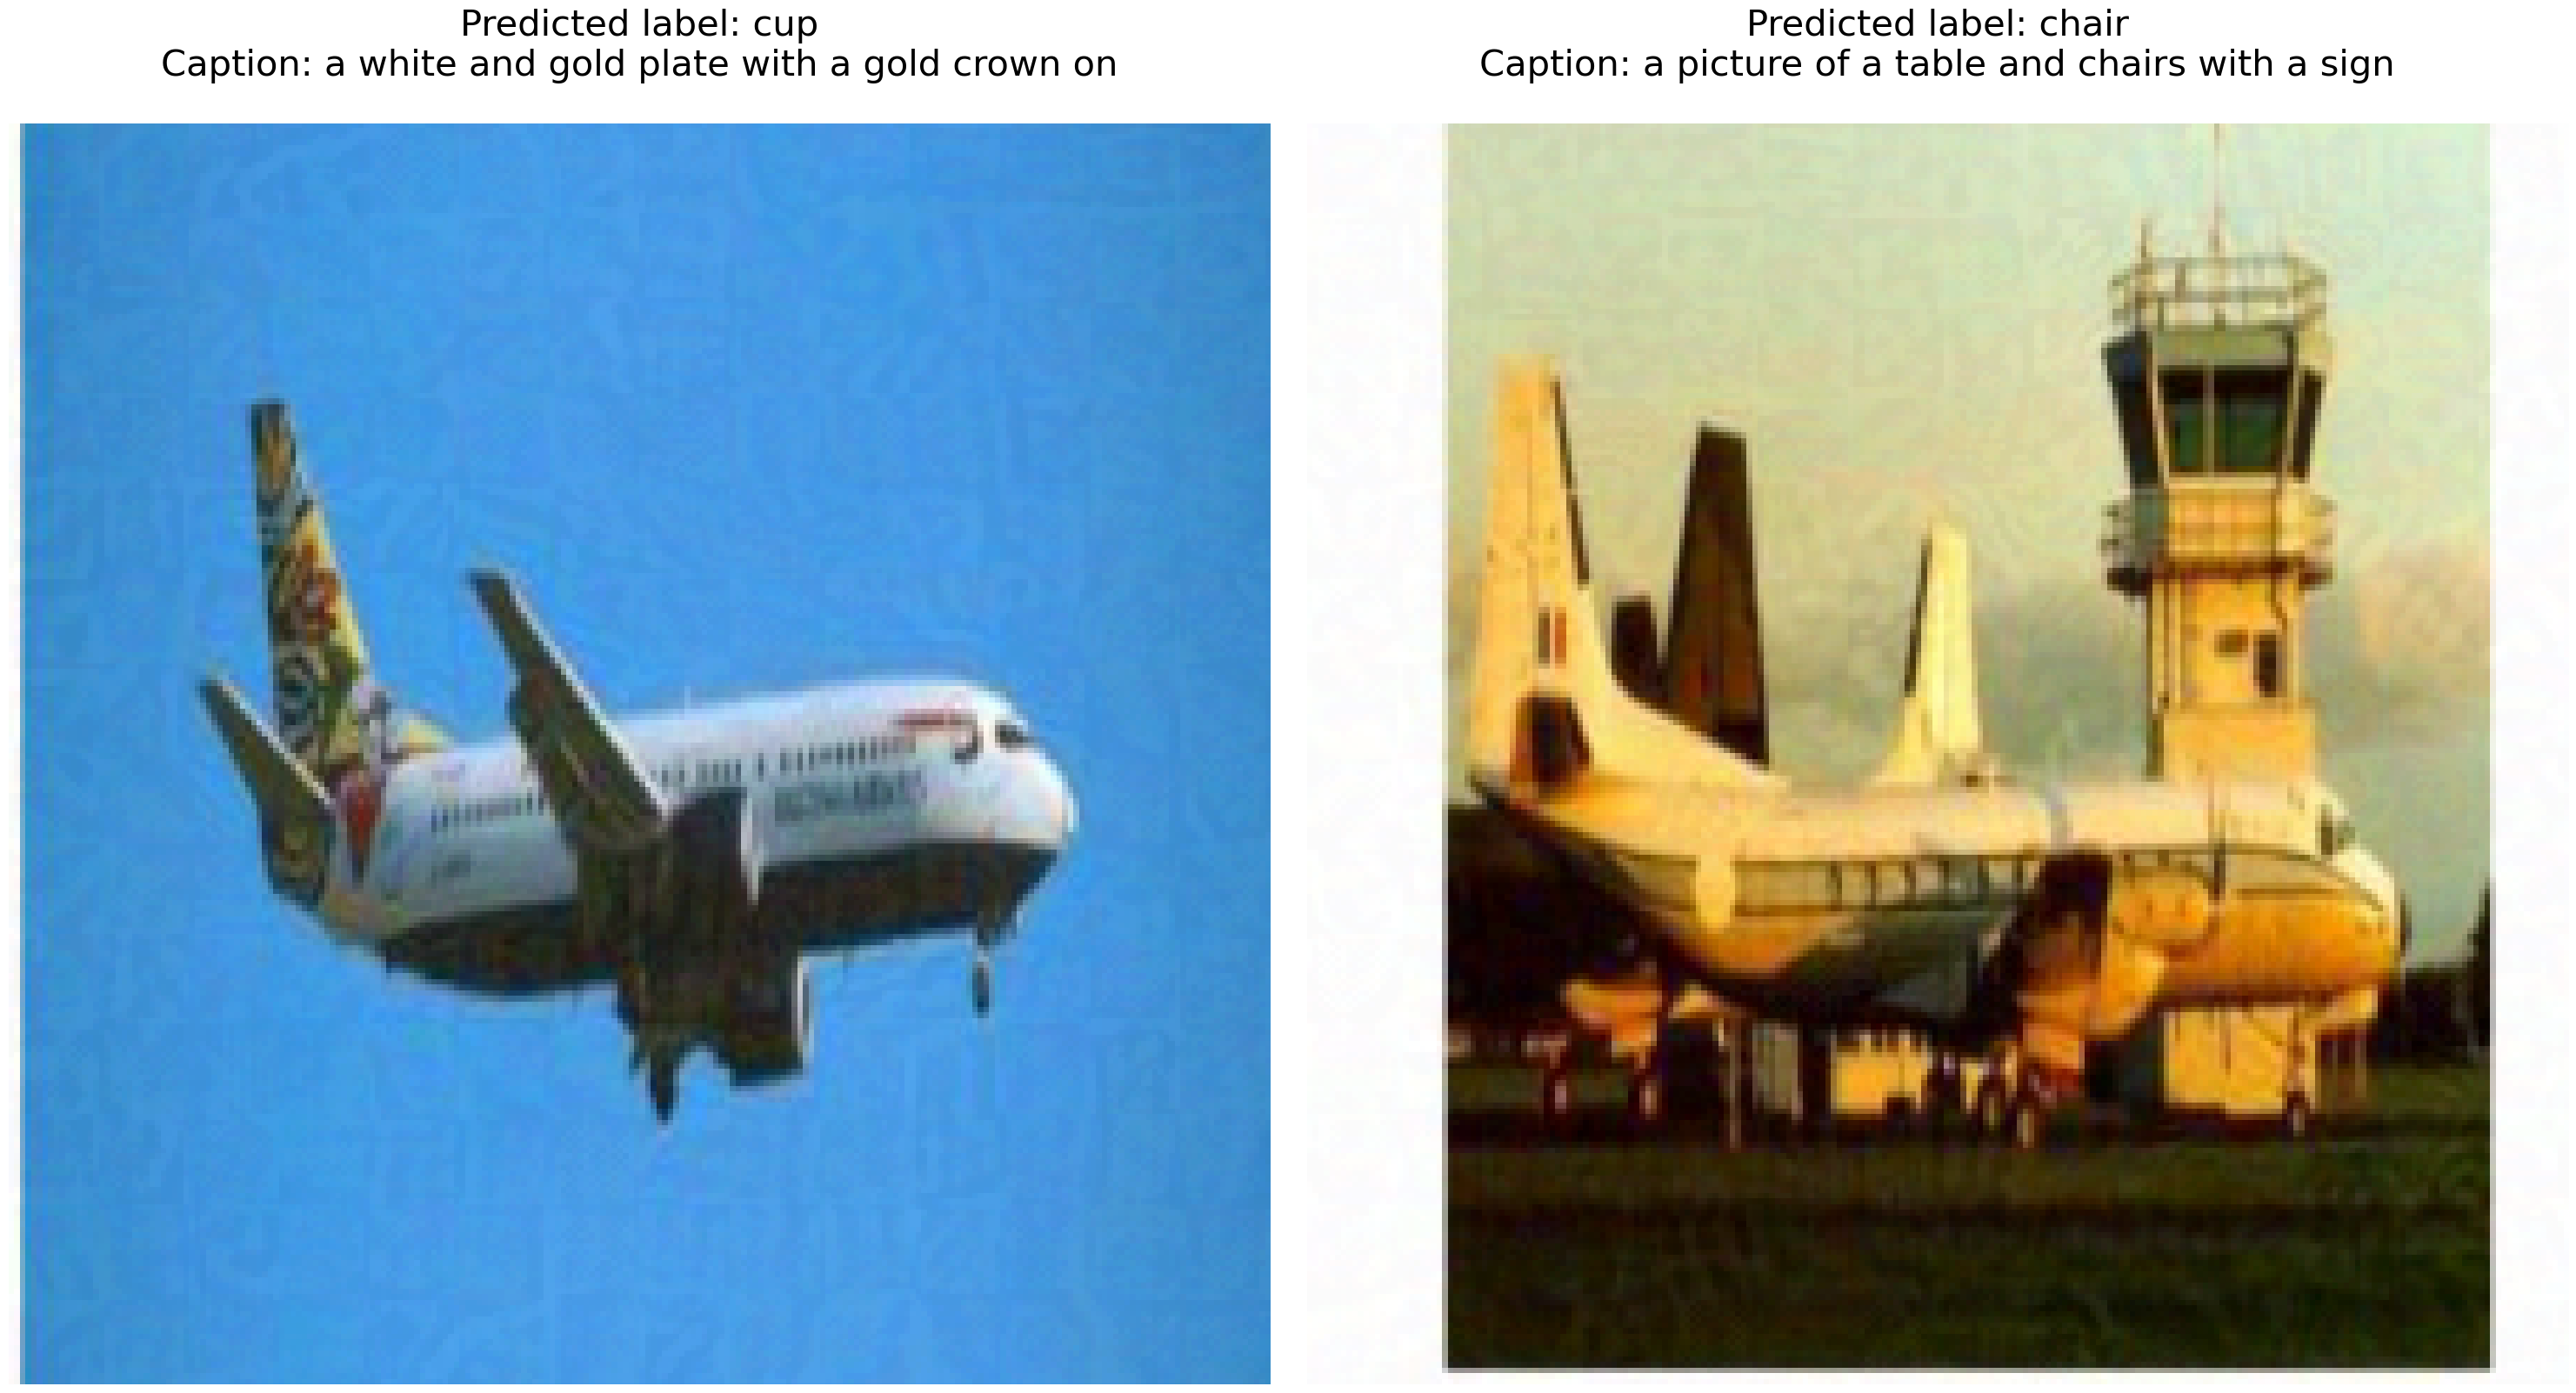

In [41]:
# Load the saved model weights
model_ft.eval()  # Set the model to evaluation mode

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(30, 15))
plt.subplots_adjust(wspace=0.5)

# Loop through the indices and process each image
for i, image_tensor in enumerate([perts[15], perts[6]]):
    # Perform inference
    with torch.no_grad():
        output = model_ft(image_tensor.unsqueeze(0).to(device))
        _, predicted_label_idx = torch.max(output, 1)
        
        predicted_label = list(ds.class_to_idx.keys())[predicted_label_idx.item()]

        inputs = {'pixel_values': image_tensor.unsqueeze(0).to(device)}
        output = model_pedik.generate(**inputs, max_new_tokens=10)
        caption = processor.decode(output[0], skip_special_tokens=True)
        

    # Display the image in the subplot
    axes[i].imshow(image_tensor.cpu().permute(1, 2, 0))
    axes[i].set_title(f'Predicted label: {predicted_label}\nCaption: {caption}\n', fontsize = 30)
    axes[i].axis('off')
# Show the plot
plt.tight_layout()
plt.show()